# PPM with implicit FCT and MULES
Apply FCT and MULES to PPM with a large time step. 
The first application of FCT should use an implicit upwind method for the bounded solution. FCT then creates a bounded correction of PPM. This can be used as the bounded solution to apply FCT again to the PPM solution. Will this process converge to a more accurate bounded solution?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import fluidfoam as foam
from initialConditions import *
from advectionSchemes import *
from fluxLimiters.fluxLimiters import *
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] =(8, 6)

JacobiSolve to tolerance 0.027357876313889487 > 1e-06 in 10 iterations


/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


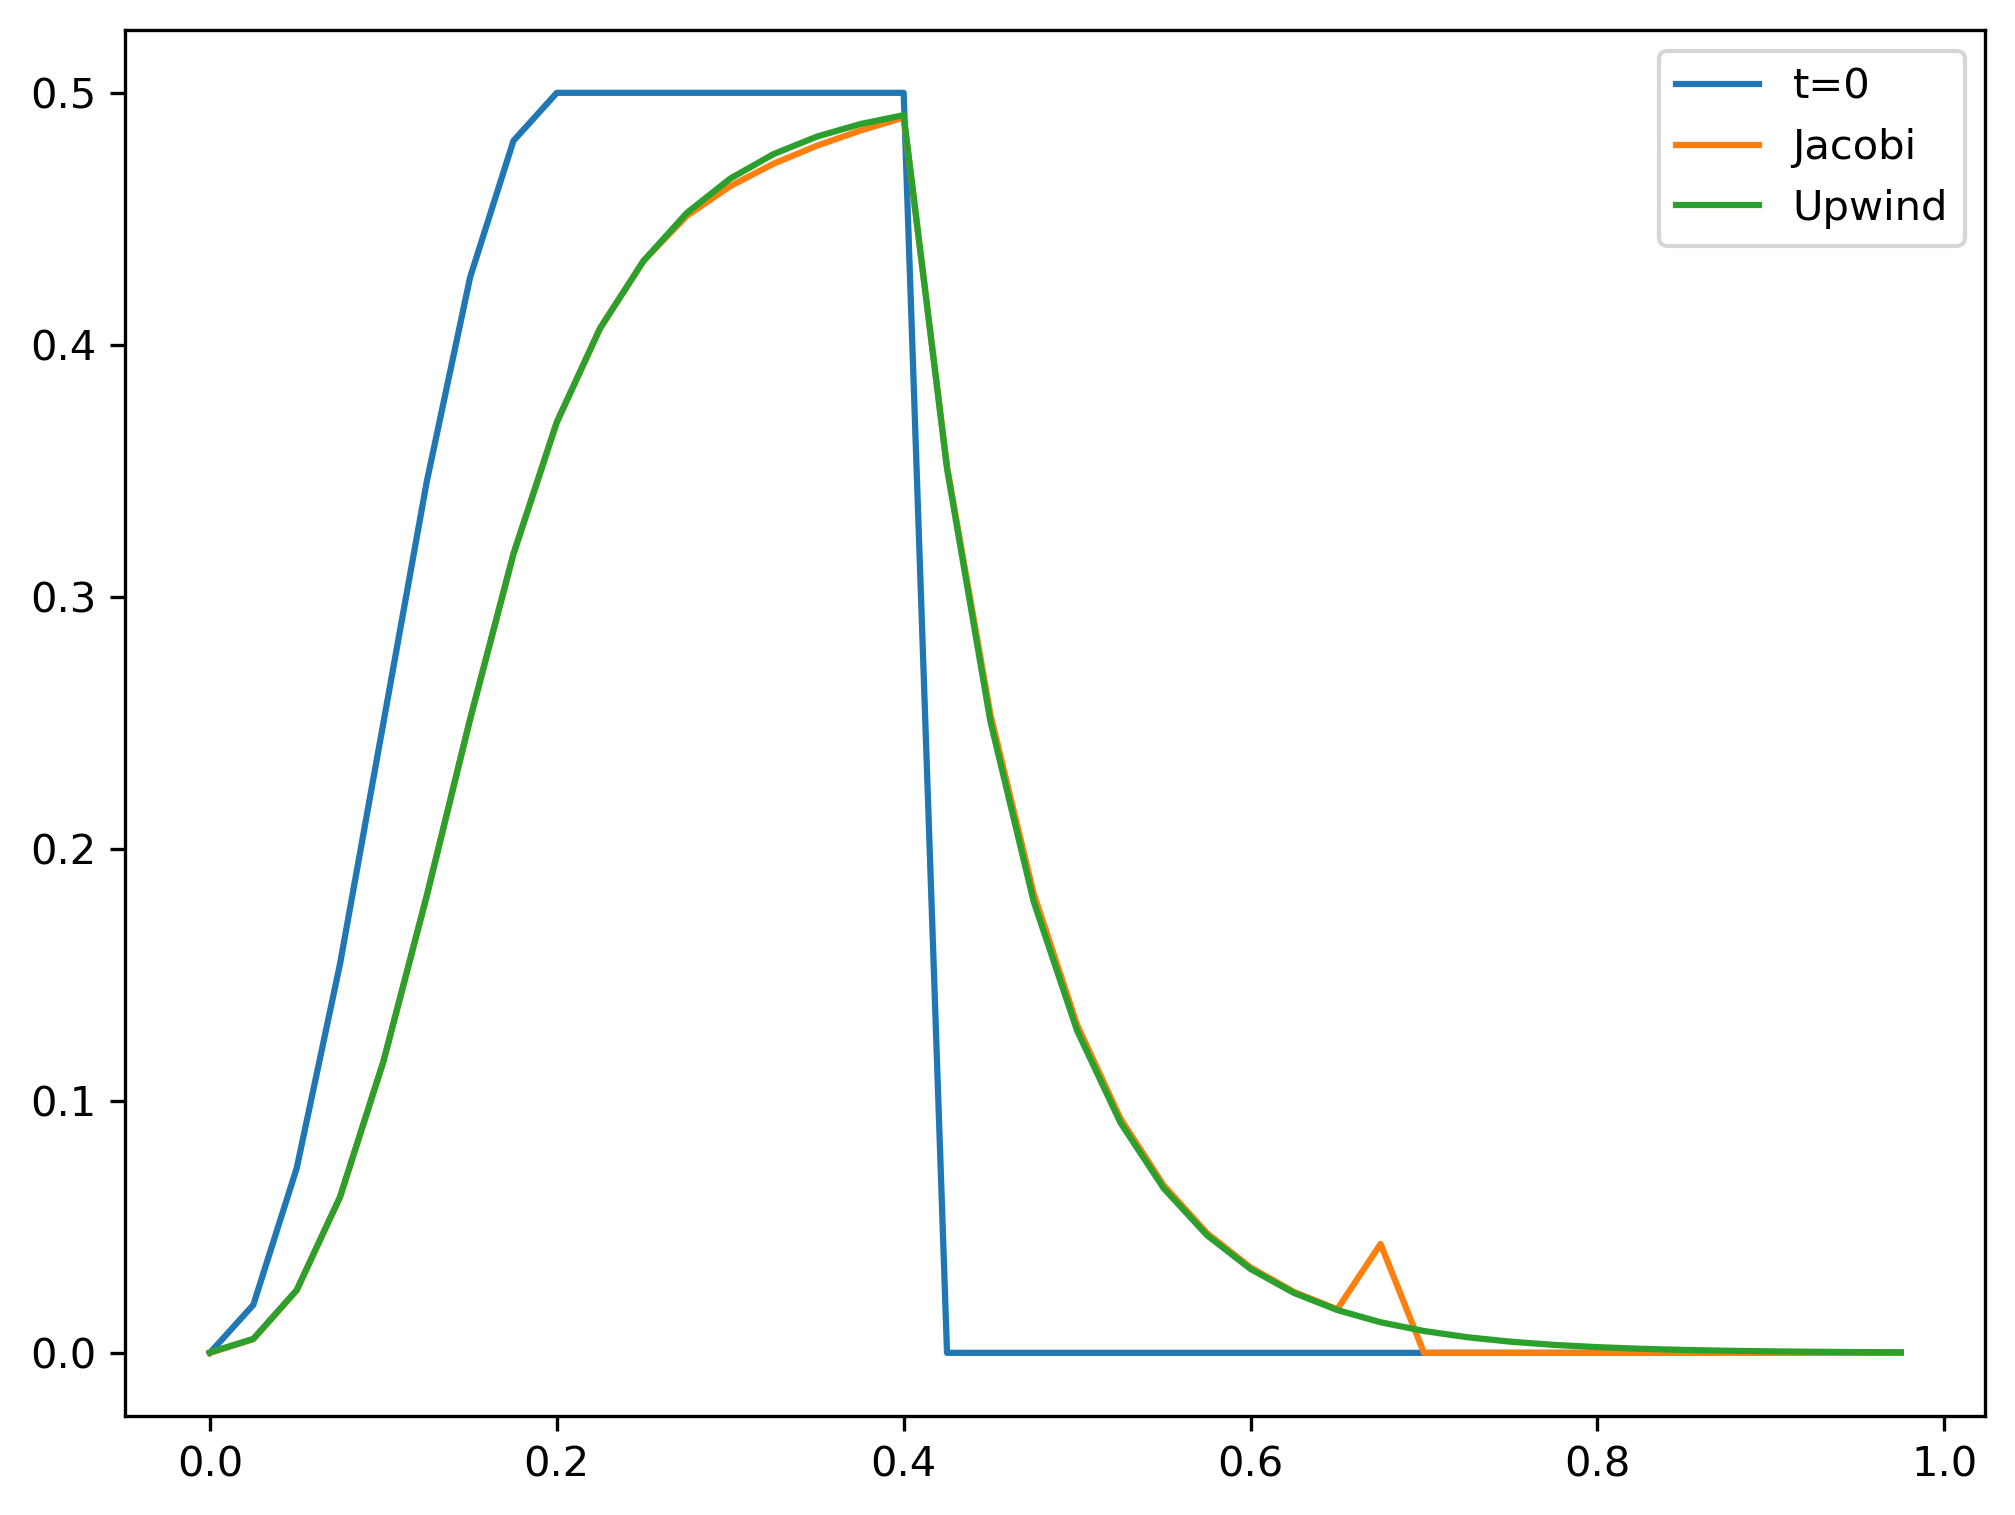

In [2]:
nx = 40
x = np.arange(0,1,1/nx)
phi = halfWave(x)
phiJ = advect(phi, 2.5, upwindFlux, options={'Jacobi': True, 'alpha': 1})
phiU = advect(phi, 2.5, upwindFlux, options={'alpha': 1})
plt.plot(x, phi, label='t=0')
plt.plot(x, phiJ, label='Jacobi')
plt.plot(x, phiU, label='Upwind')
plt.legend()
plt.show()

In [3]:
# Function for schemes comparisions

def compareSchemes(params, fluxes, options, labels, OFcases = [], OFtimes=[], OFfields=[],
                    OFlabels = []):
    """Solve the advection equation for various schemes and plot the results
    params: dict with entries "nt", "nx", "c", "initialConditions", "title", "fileName"
    fluxes: List of flux functions
    options: List of dictionaries to send to the flux functions
    labels:  Labels for the legend of the graph for each flux function
    """
    dt = params["c"]/params["nx"]
    dx = 1/params["nx"]
    print('Solving the advection equation for', dt*params["nt"],
          'revolutions of a periodic domain with spatial resolution', dx)
    x = np.arange(0,1, dx)
    phi0 = params["initialConditions"](x)
    phiE = params["initialConditions"]((x-dt*params["nt"])%1)
    #fig,ax = plt.subplots(1,2, figsize=(12,4), layout='constrained')
    #fig.sup
    plt.title(params["title"]+'\nc = '+str(round(params["c"],2))+' nx = '
              +str(params["nx"]) + ' nt = '+str(params["nt"]))
    plt.plot(x, phi0, 'k--', label = 't=0')
    plt.plot(x, phiE, 'k', label='t='+str(round(dt*params["nt"],2)))
    plt.axhline(y=0, color='k', ls=':', lw=0.5)
    plt.axhline(y=1, color='k', ls=':', lw=0.5)

    # Run all the schemes and plot the results
    lines = ['k-o', 'r-+', 'b-x', 'g--s', 'c--', 'm:', 'k:', 'r:', 'b:', 'c:', 'g:']
    for flux, name, option, line in zip(fluxes, labels, options, lines):
        phi = phi0.copy()
        for it in range(params["nt"]):
            phi = advect(phi, params["c"], flux, options=option)
        plt.plot(x, phi, line, label=name)
        #ax[1].plot(x, phi - phiE, label=name)

    # Add the OpenFOAM results
    lines = lines[len(fluxes):-1]
    for case, time, field, label, line in zip(OFcases, OFtimes,OFfields,OFlabels,lines):
        phi = foam.readscalar(case, str(time), field)
        plt.plot(x, phi, line, label=label)
    
    plt.legend()#bbox_to_anchor=(1.1, 1))
    #ax[0].set(ylabel=r'$\psi$', title = 'Totals', xlim=[0,1])
    #ax[1].set(ylabel='Error', title = 'Errors', xlim=[0,1])
    plt.xlim([0,1])
    plt.savefig(params["fileName"])
    plt.show()

# calculate the number of time steps from the number of revolutions, nx and c
nt = lambda nRevs, nx, c : int(nRevs*nx/c)


Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.025


/home/hilary/python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


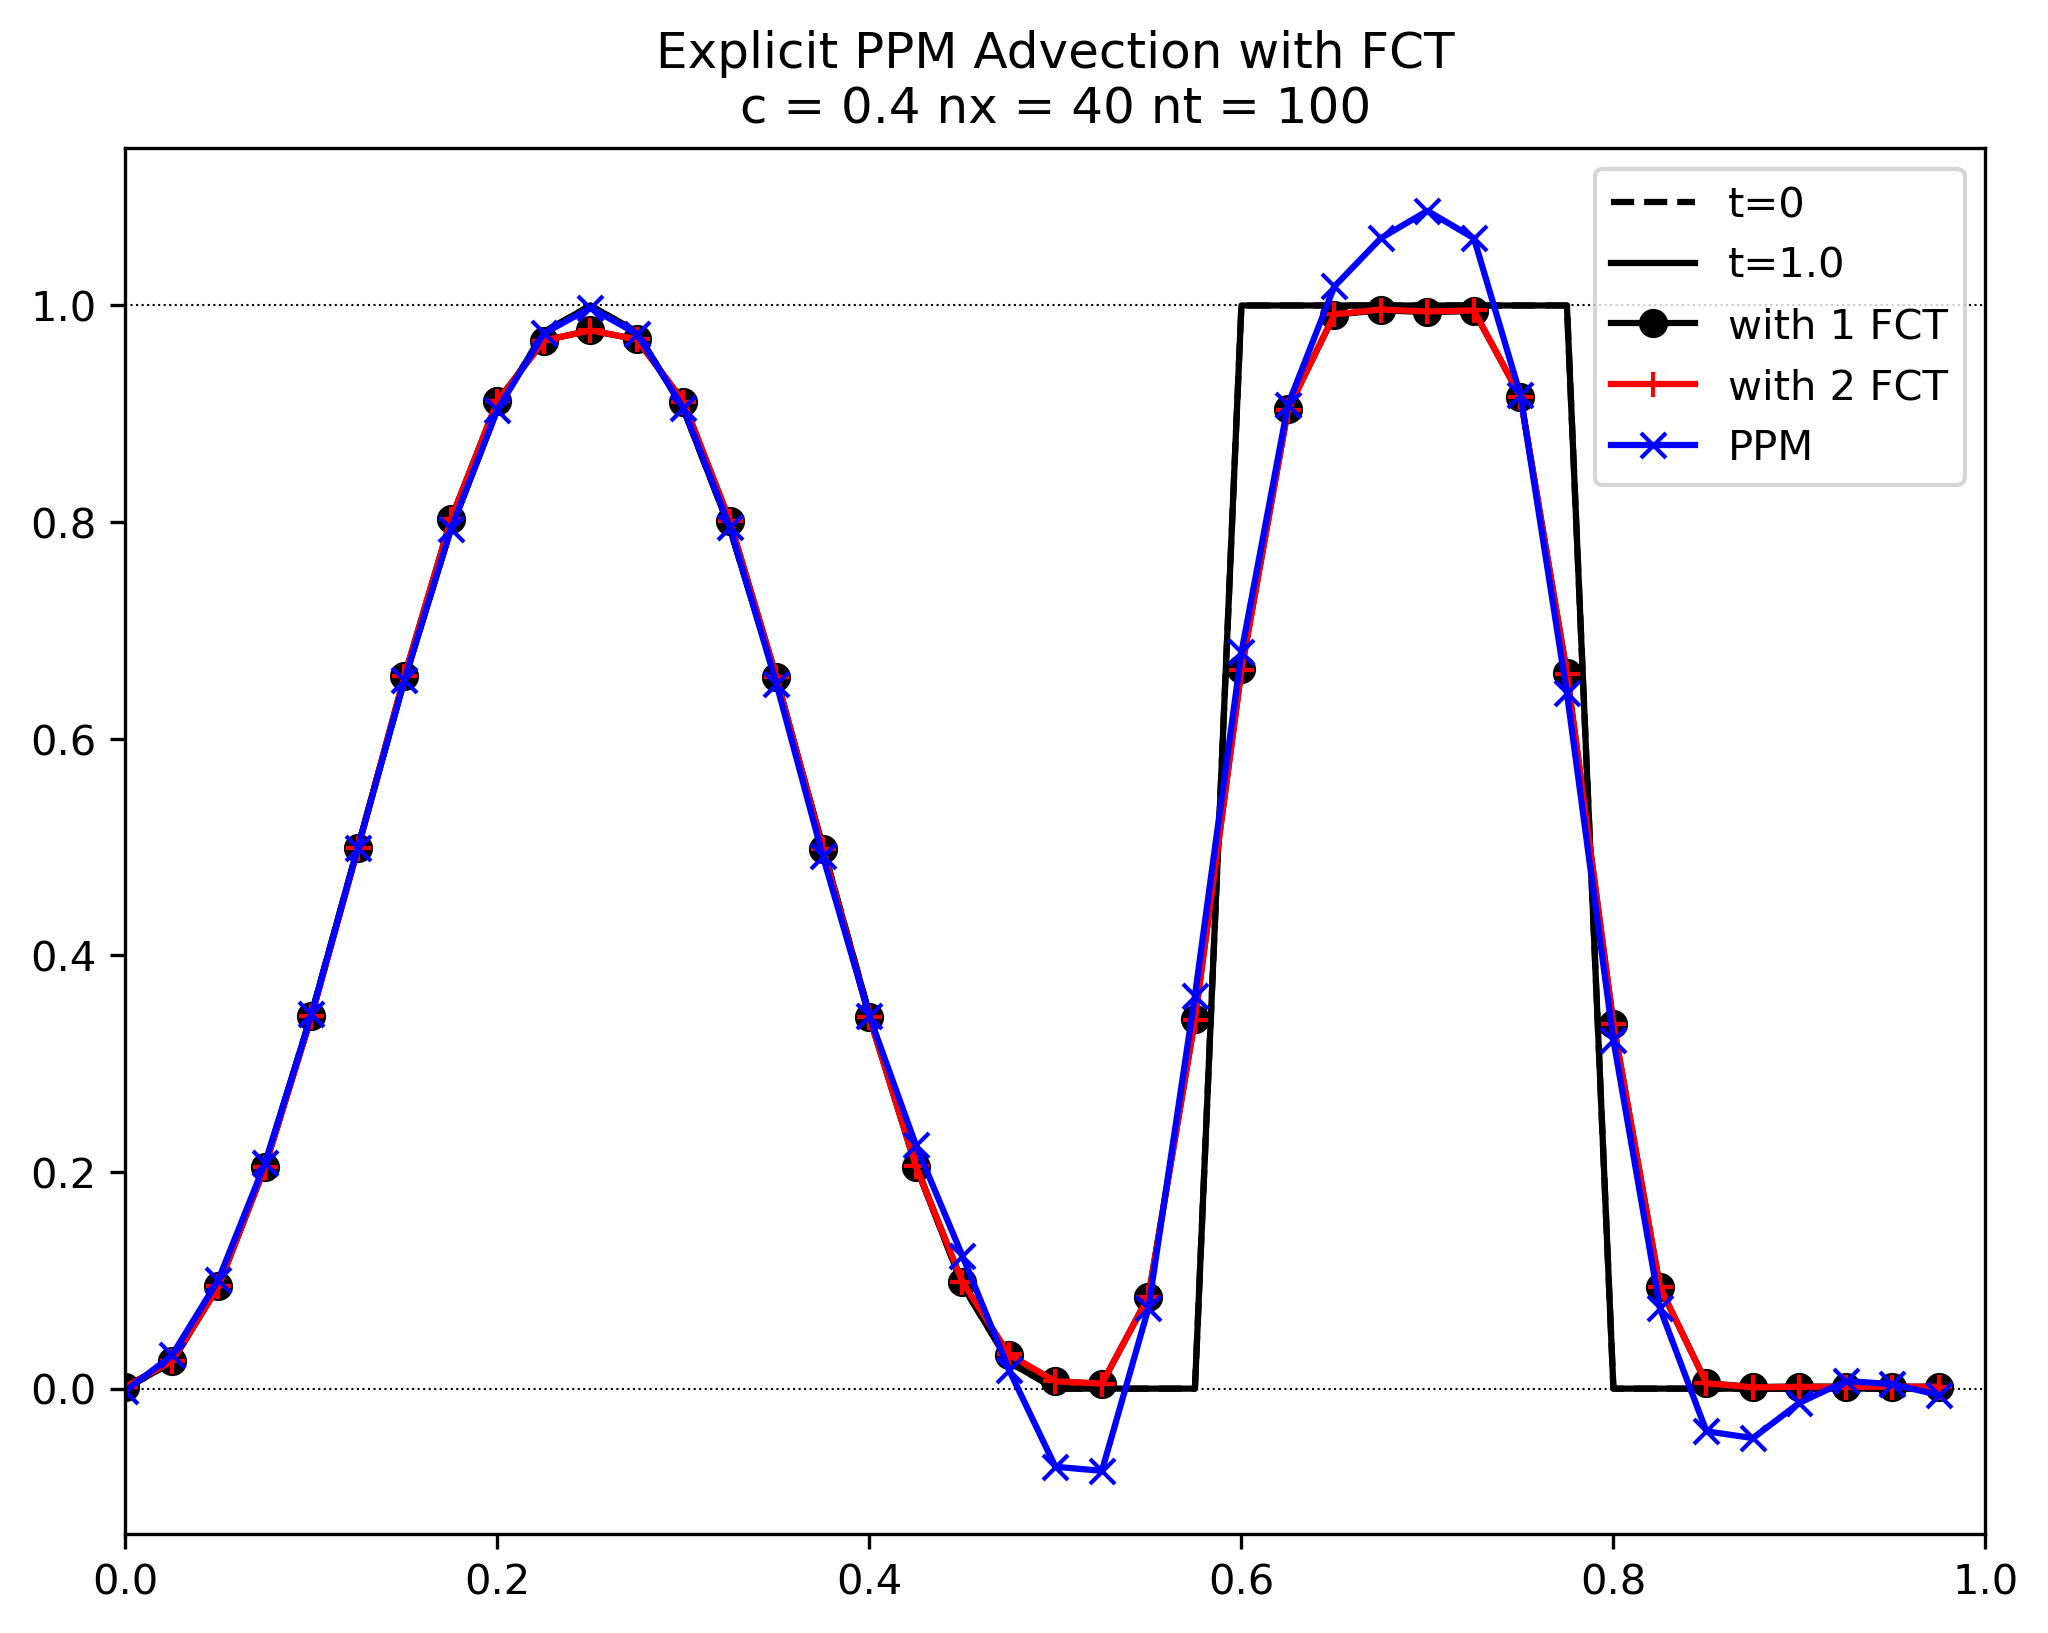

In [6]:
# Explicit PPM with FCT
compareSchemes(
    {"nt": nt(1,40,.4), "nx":40, "c":0.4, "initialConditions":combi,
     "title": "Explicit PPM Advection with FCT",
     "fileName": "plots/PPM_c04_FCT.pdf"},
    [FCT, FCT, PPMflux],
    [{"nCorr": 1}, {"nCorr": 2}, {}],
    ['with 1 FCT', 'with 2 FCT', 'PPM'])


Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.025


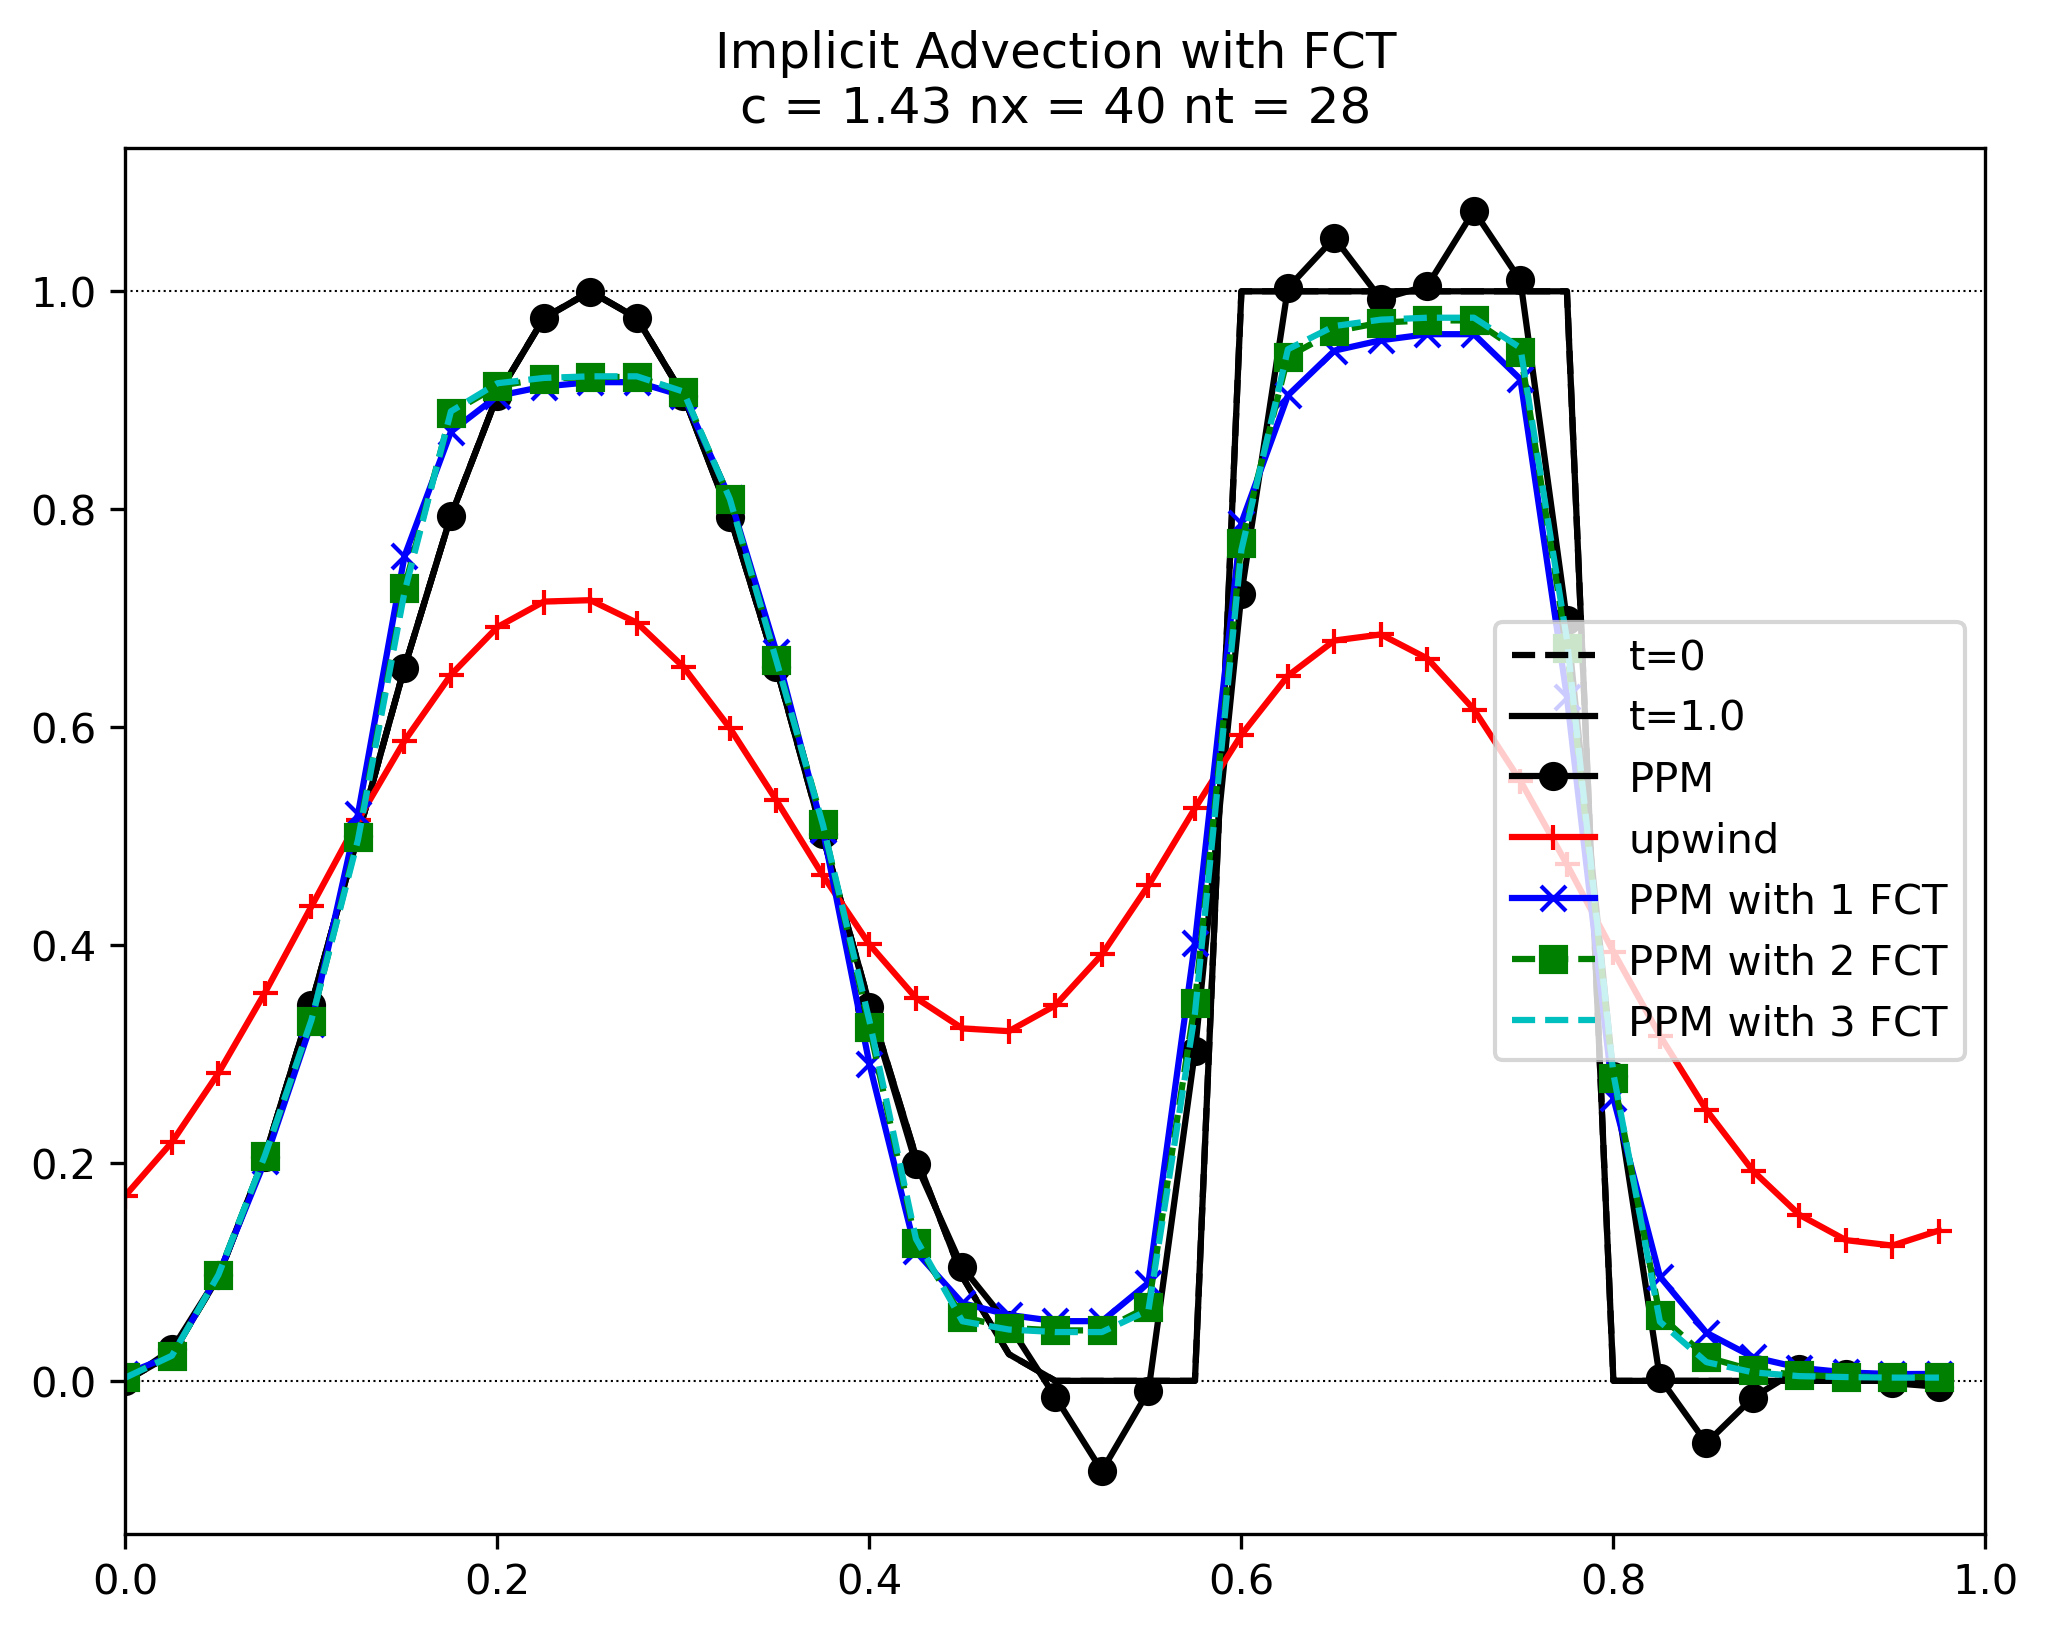

In [7]:
# PPM with iterations of implicit, monotonic FCT with c = 1.4
compareSchemes(
    {"nt": 28, "nx":40, "c":40/28, "initialConditions":combi,
     "title": "Implicit Advection with FCT",
     "fileName": "plots/PPM_c14_FCT.pdf"},
    [PPMflux, upwindFlux, FCT, FCT, FCT],
    [{}, {}, {"nCorr": 1}, {"nCorr": 2}, {"nCorr": 3}],
    ['PPM', 'upwind', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT'])

Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.0125


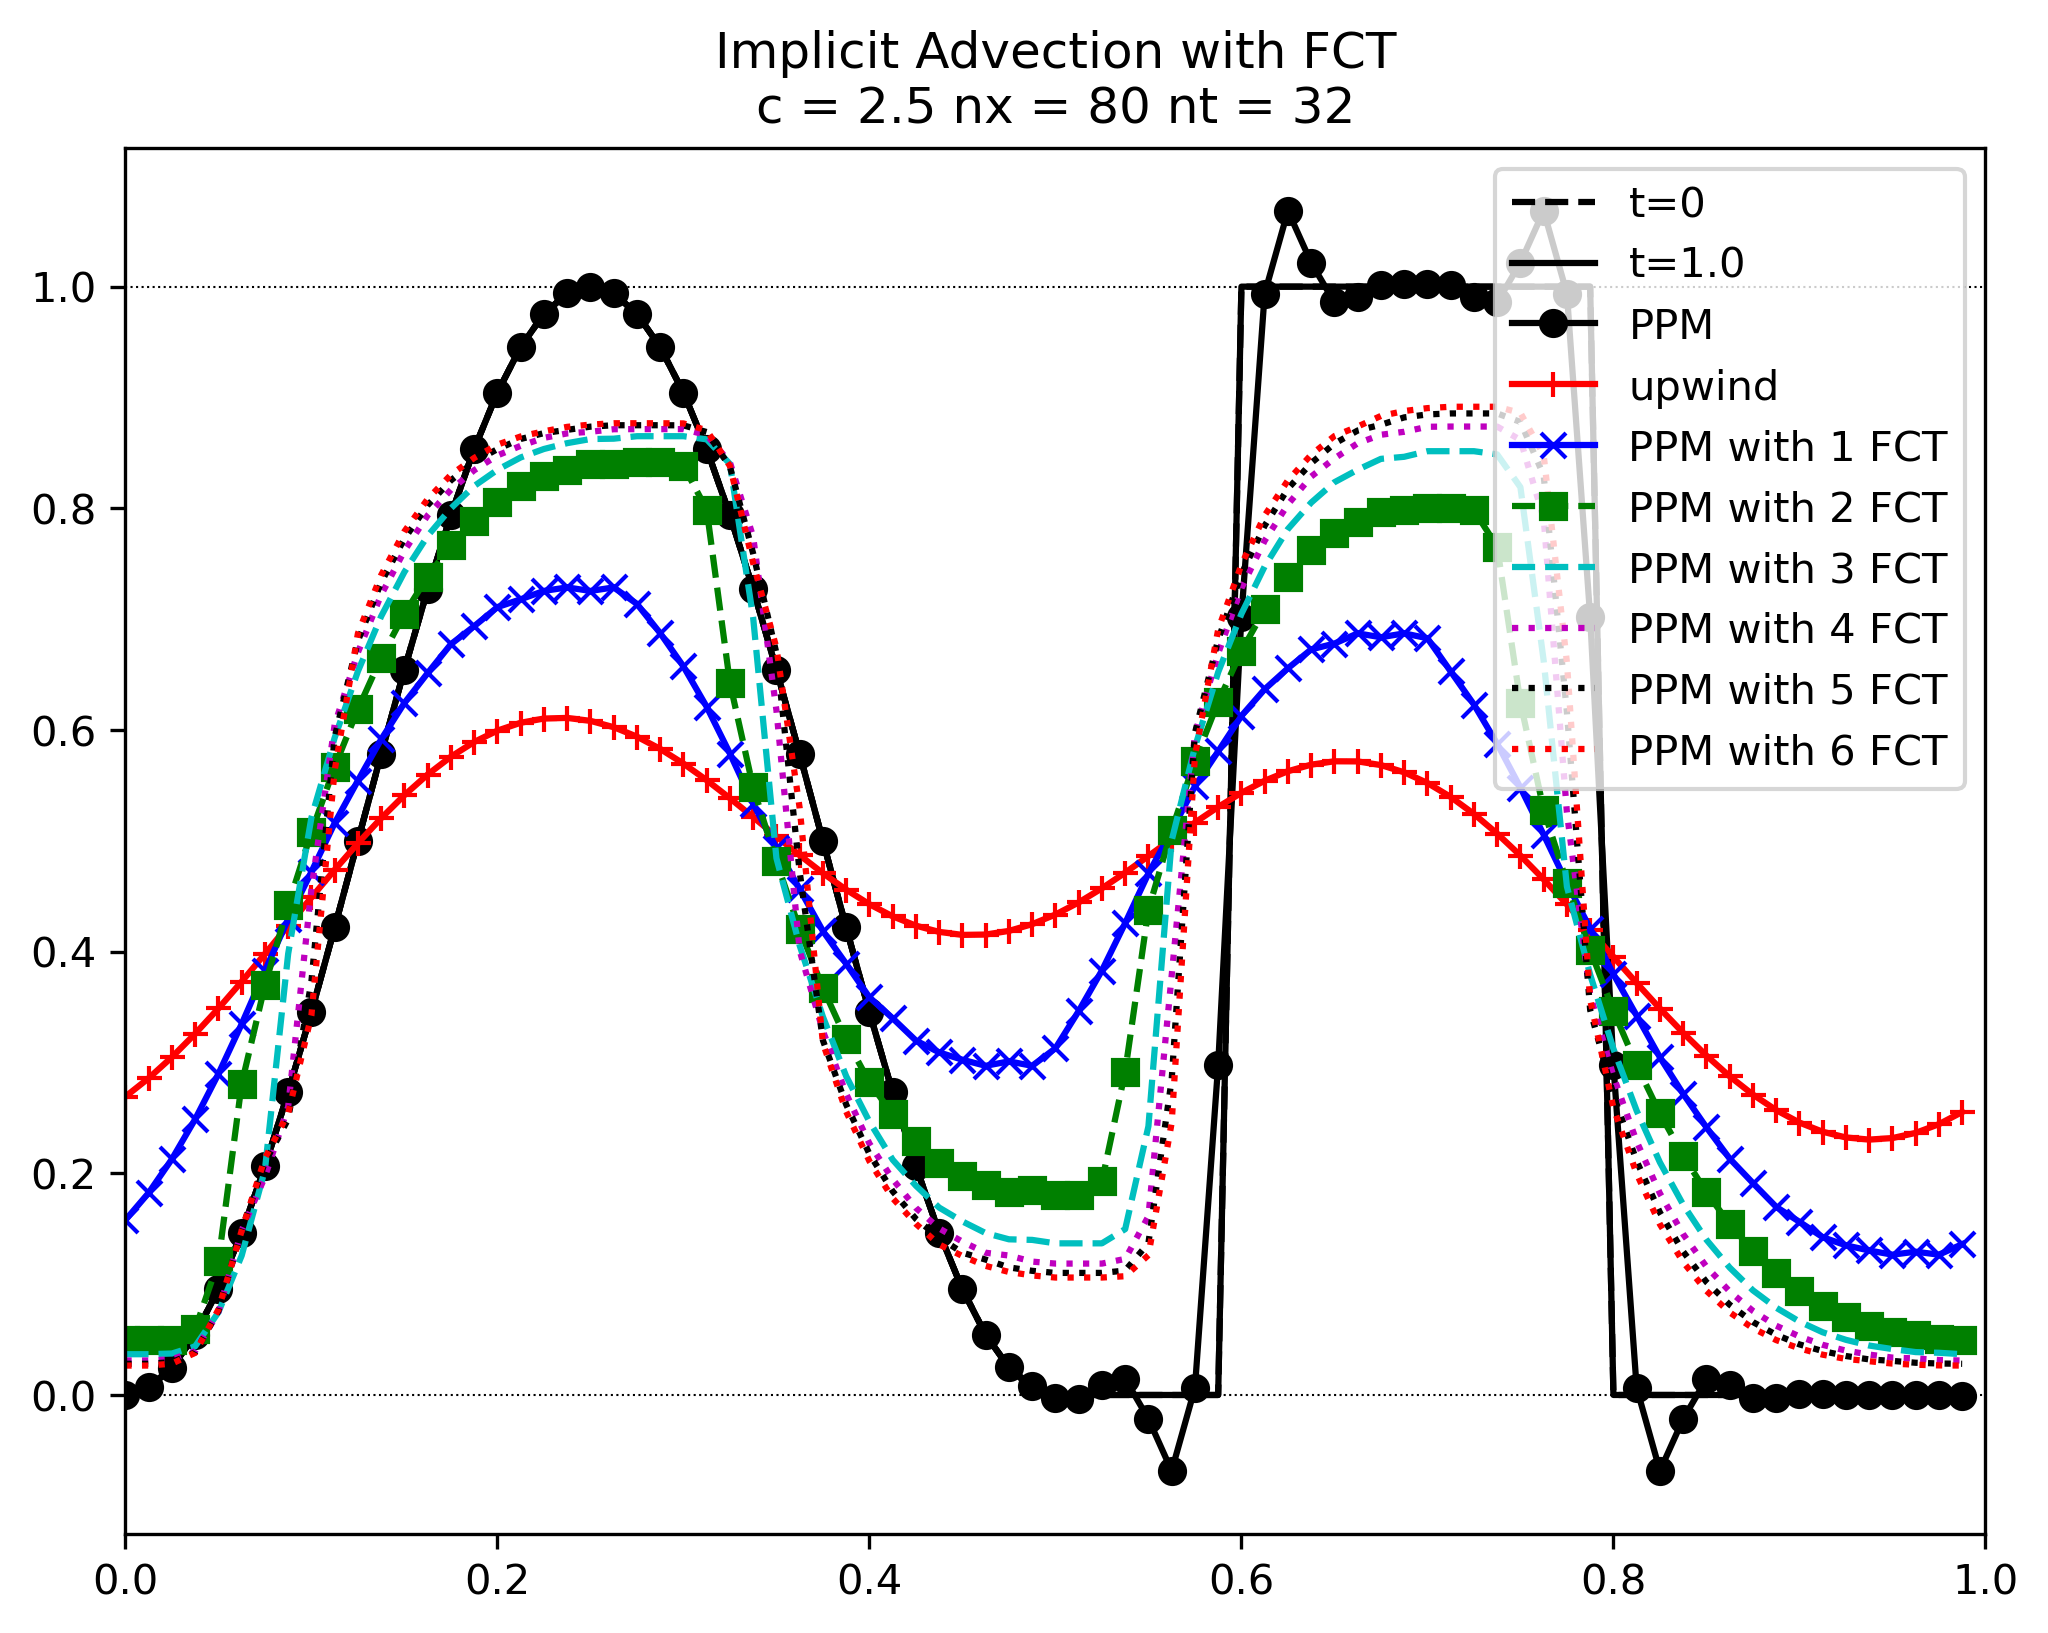

In [8]:
# PPM with iterations of implicit, monotonic FCT with c = 2.4
compareSchemes(
    {"nt": 32, "nx":80, "c":80/32, "initialConditions":combi,
     "title": "Implicit Advection with FCT",
     "fileName": "plots/PPM_c24_FCT.pdf"},
    [PPMflux, upwindFlux, FCT, FCT, FCT, FCT, FCT, FCT],
    [{}, {}, {"nCorr": 1}, {"nCorr": 2}, {"nCorr": 3}, {"nCorr": 4}, {"nCorr": 5},
     {"nCorr": 6}],
    ['PPM', 'upwind', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT',
     'PPM with 4 FCT', 'PPM with 5 FCT', 'PPM with 6 FCT'])

Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.0125


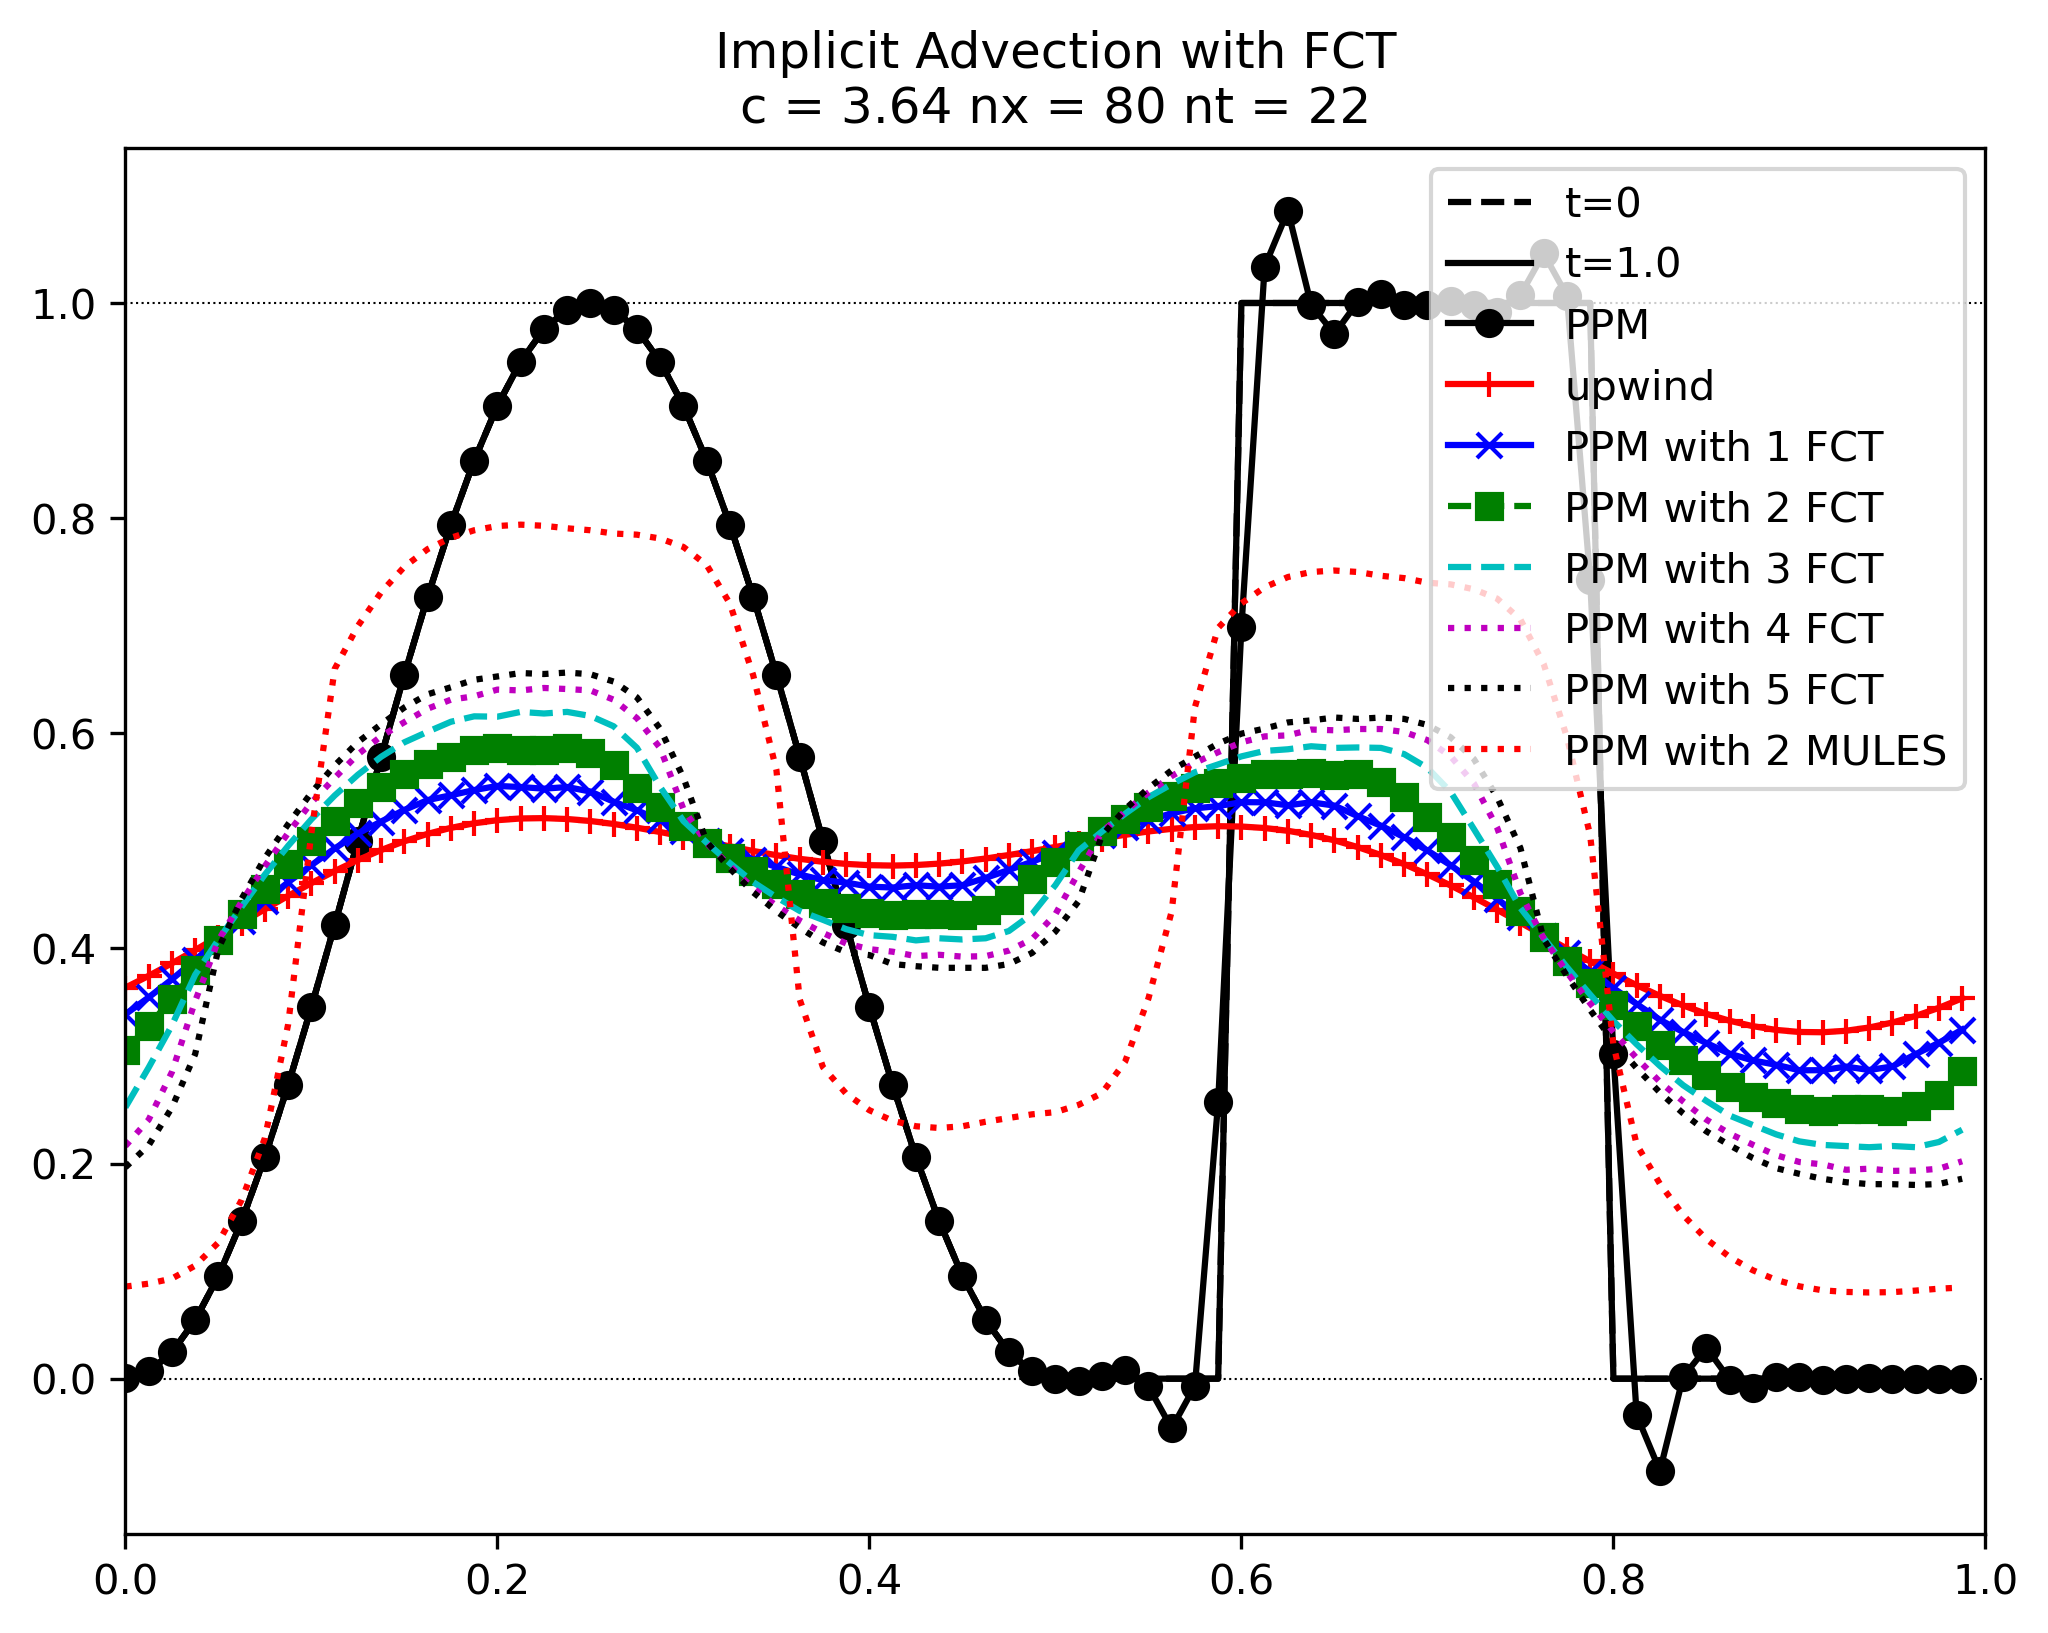

In [9]:
# PPM with iterations of implicit, monotonic FCT with c = 3.6
compareSchemes(
    {"nt": 22, "nx":80, "c":80/22, "initialConditions":combi,
     "title": "Implicit Advection with FCT",
     "fileName": "plots/PPM_c36_FCT.pdf"},
    [PPMflux, upwindFlux, FCT, FCT, FCT, FCT, FCT, MULES],
    [{}, {}, {"nCorr": 1}, {"nCorr": 2}, {"nCorr": 3}, {"nCorr": 4}, {"nCorr": 5},
     {"nCorr": 2}],
    ['PPM', 'upwind', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT',
     'PPM with 4 FCT', 'PPM with 5 FCT', 'PPM with 2 MULES'])

Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.0125


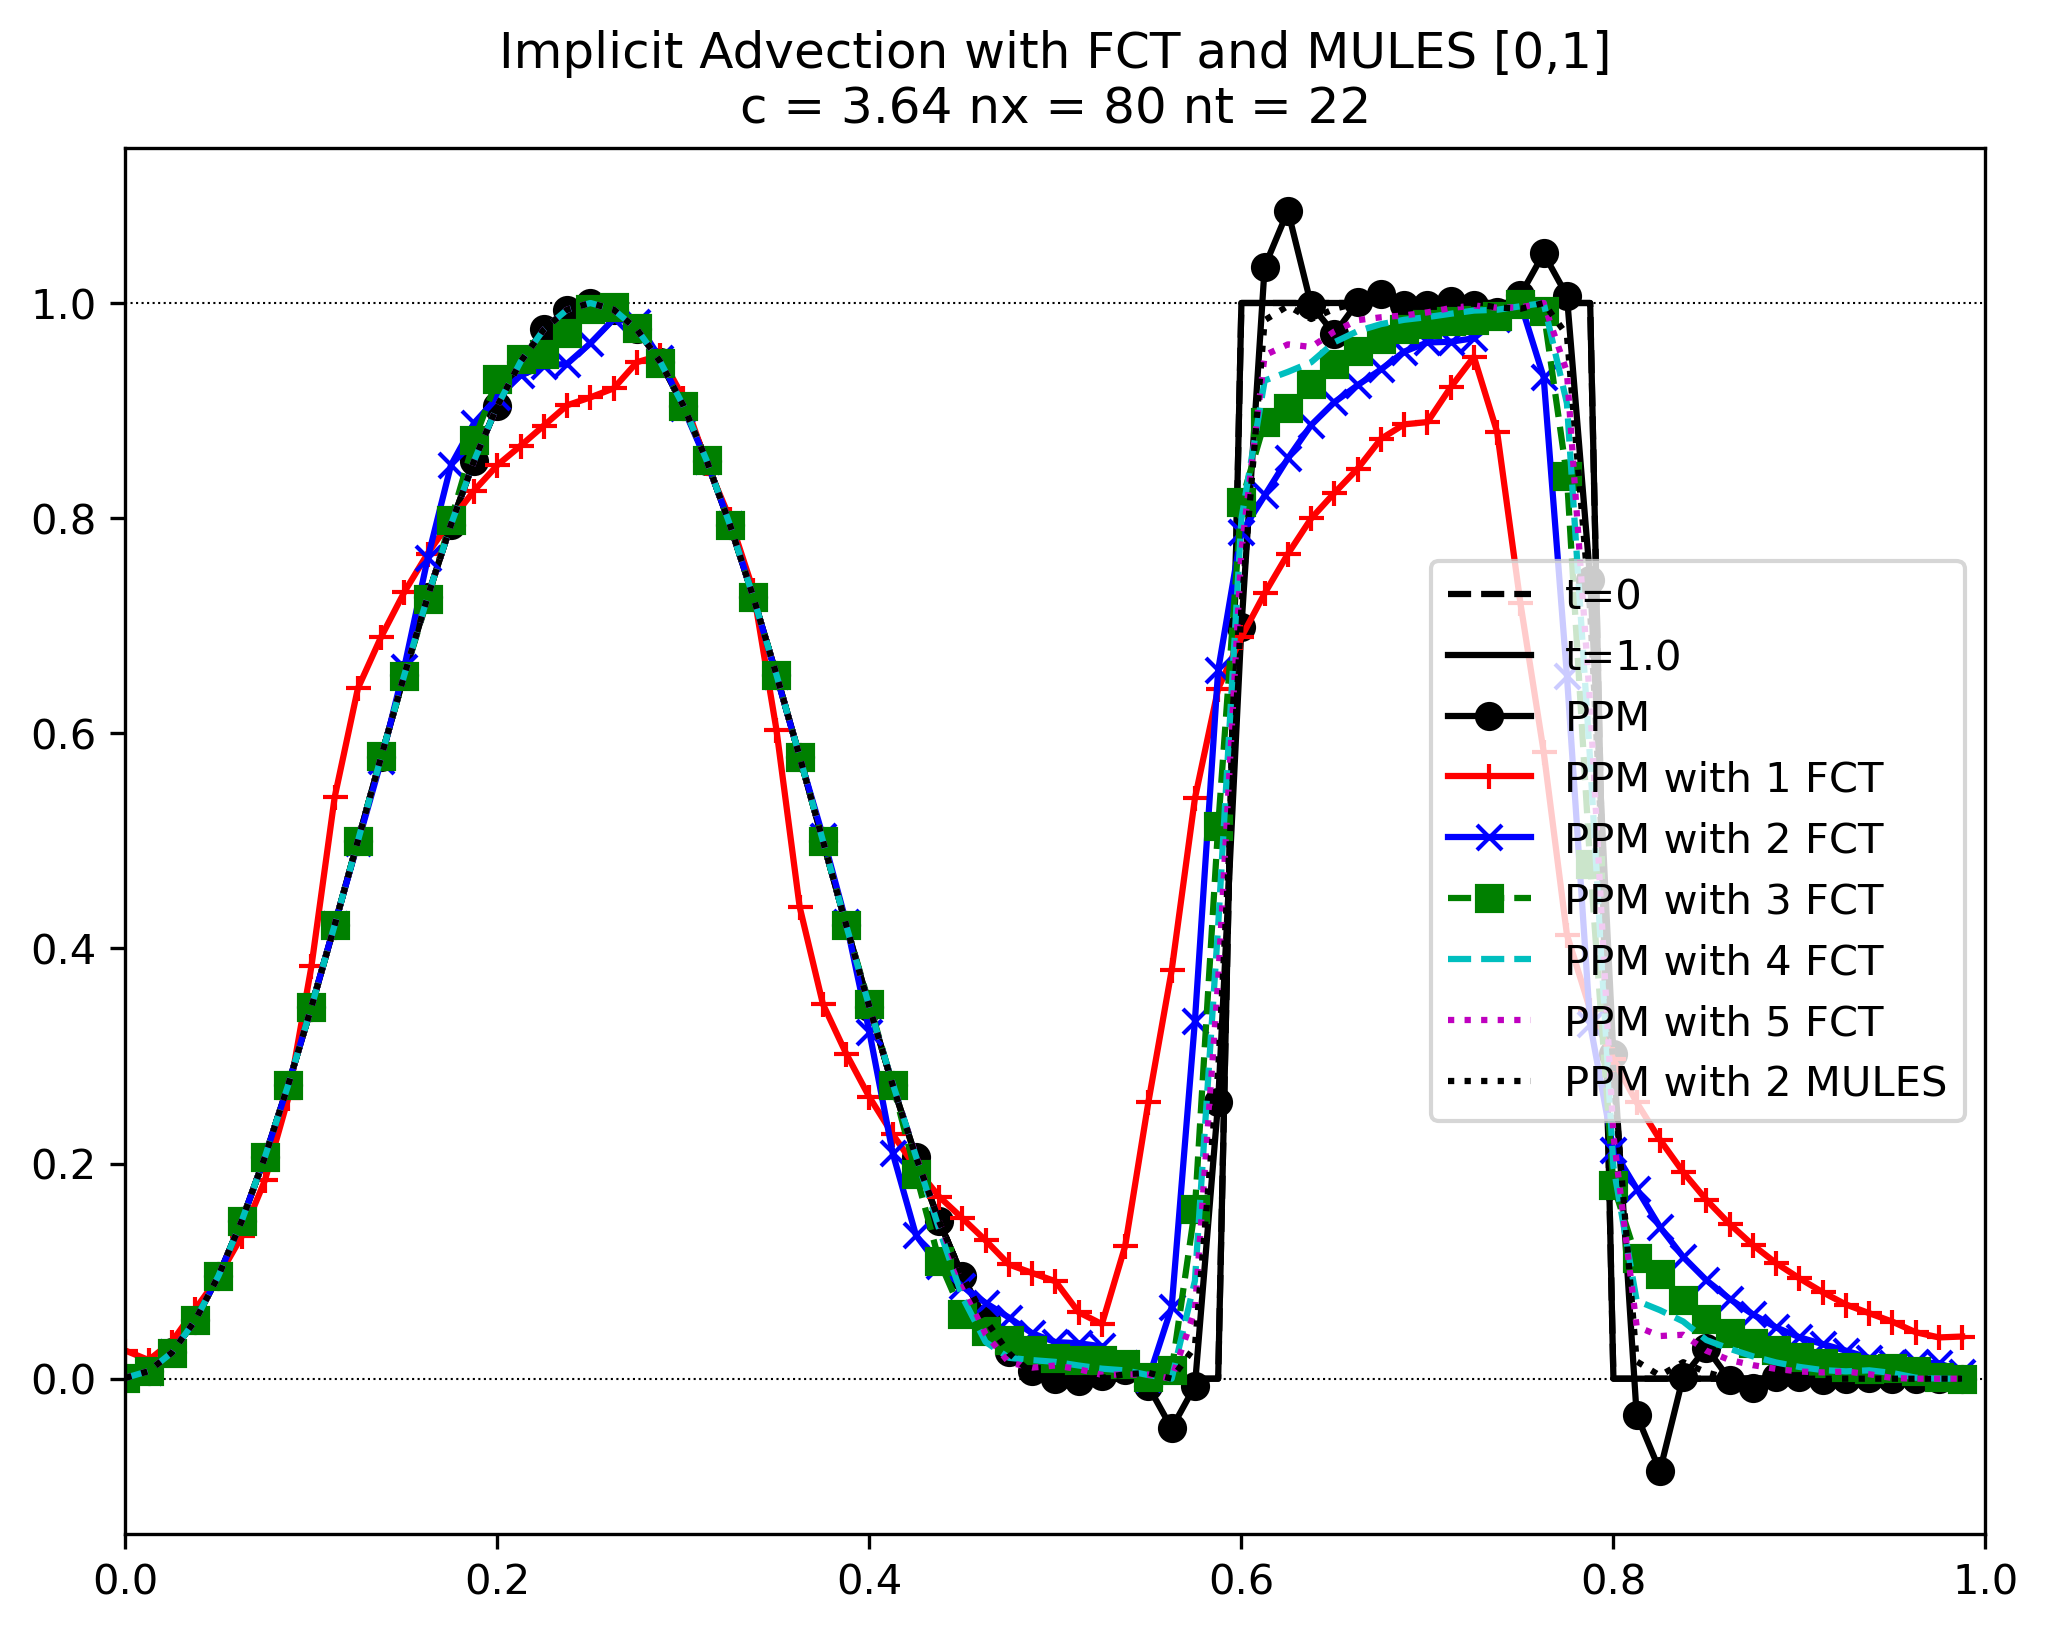

In [10]:
# PPM with iterations of implicit, monotonic FCT[0,1] with c = 3.6
compareSchemes(
    {"nt": 22, "nx":80, "c":80/22, "initialConditions":combi,
     "title": "Implicit Advection with FCT and MULES [0,1]",
     "fileName": "plots/PPM_c36_FCT01.pdf"},
    [PPMflux, FCT, FCT, FCT, FCT, FCT, MULES],
    [{}, {"nCorr": 1, "minPhi":0, "maxPhi":1},
             {"nCorr": 2, "minPhi":0, "maxPhi":1},
             {"nCorr": 3, "minPhi":0, "maxPhi":1},
             {"nCorr": 4, "minPhi":0, "maxPhi":1},
             {"nCorr": 5, "minPhi":0, "maxPhi":1},
             {"nCorr": 2, "minPhi":0, "maxPhi":1}],
    ['PPM', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT',
     'PPM with 4 FCT', 'PPM with 5 FCT', 'PPM with 2 MULES'])

Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.0125


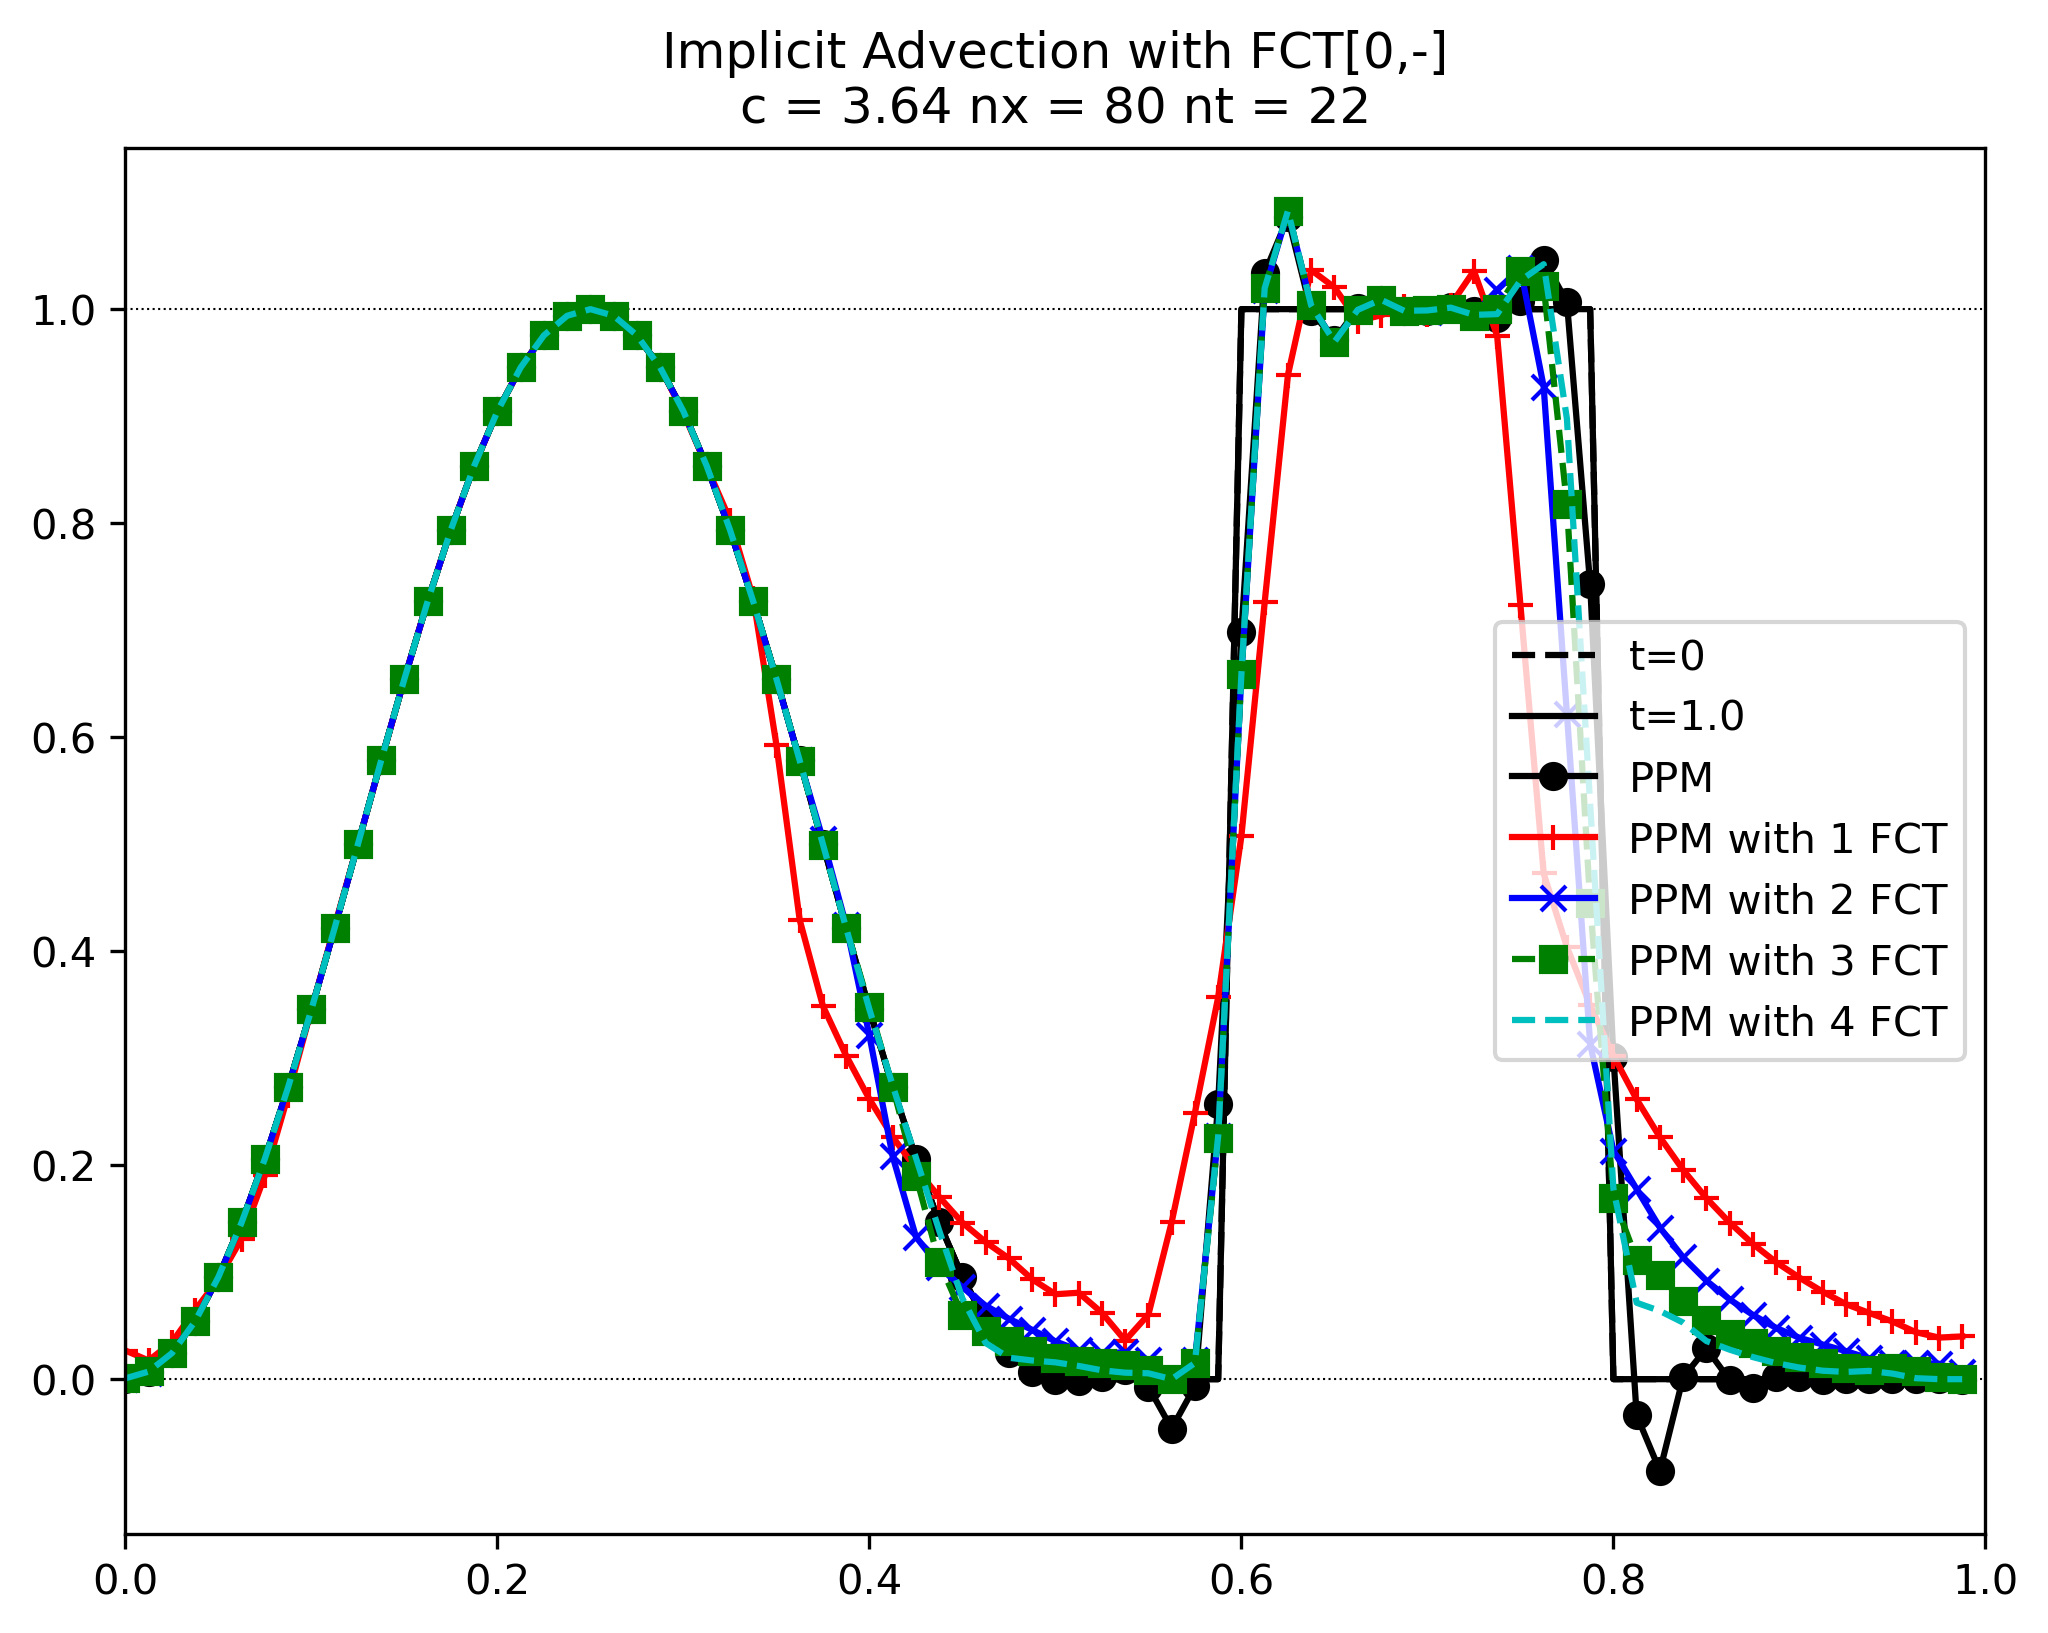

In [11]:
# PPM with iterations of implicit, monotonic FCT[0,] with c = 3.6
compareSchemes(
    {"nt": 22, "nx":80, "c":80/22, "initialConditions":combi,
     "title": "Implicit Advection with FCT[0,-]",
     "fileName": "plots/PPM_c36_FCT0-.pdf"},
    [PPMflux, FCT, FCT, FCT, FCT],
    [{}, {"nCorr": 1, "minPhi":0, "maxPhi":1000},
             {"nCorr": 2, "minPhi":0, "maxPhi":1000},
             {"nCorr": 3, "minPhi":0, "maxPhi":1000},
             {"nCorr": 4, "minPhi":0, "maxPhi":1000}],
    ['PPM', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT',
     'PPM with 4 FCT'])

Solving the advection equation for 1.0 revolutions of a periodic domain with spatial resolution 0.0125
JacobiSolve to tolerance 0.038181540549321366 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.02243334643617239 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.021137297060717215 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.02035948212575004 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.02083366132615989 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.019823620484078278 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.020147217774828335 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.01955251234014514 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.019659146720246042 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.019450514134727273 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.01927818067441263 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.01928232949821246 > 1e-06 in 10 iterations
JacobiSolve to tolerance 0.019009532594003564 > 1e-

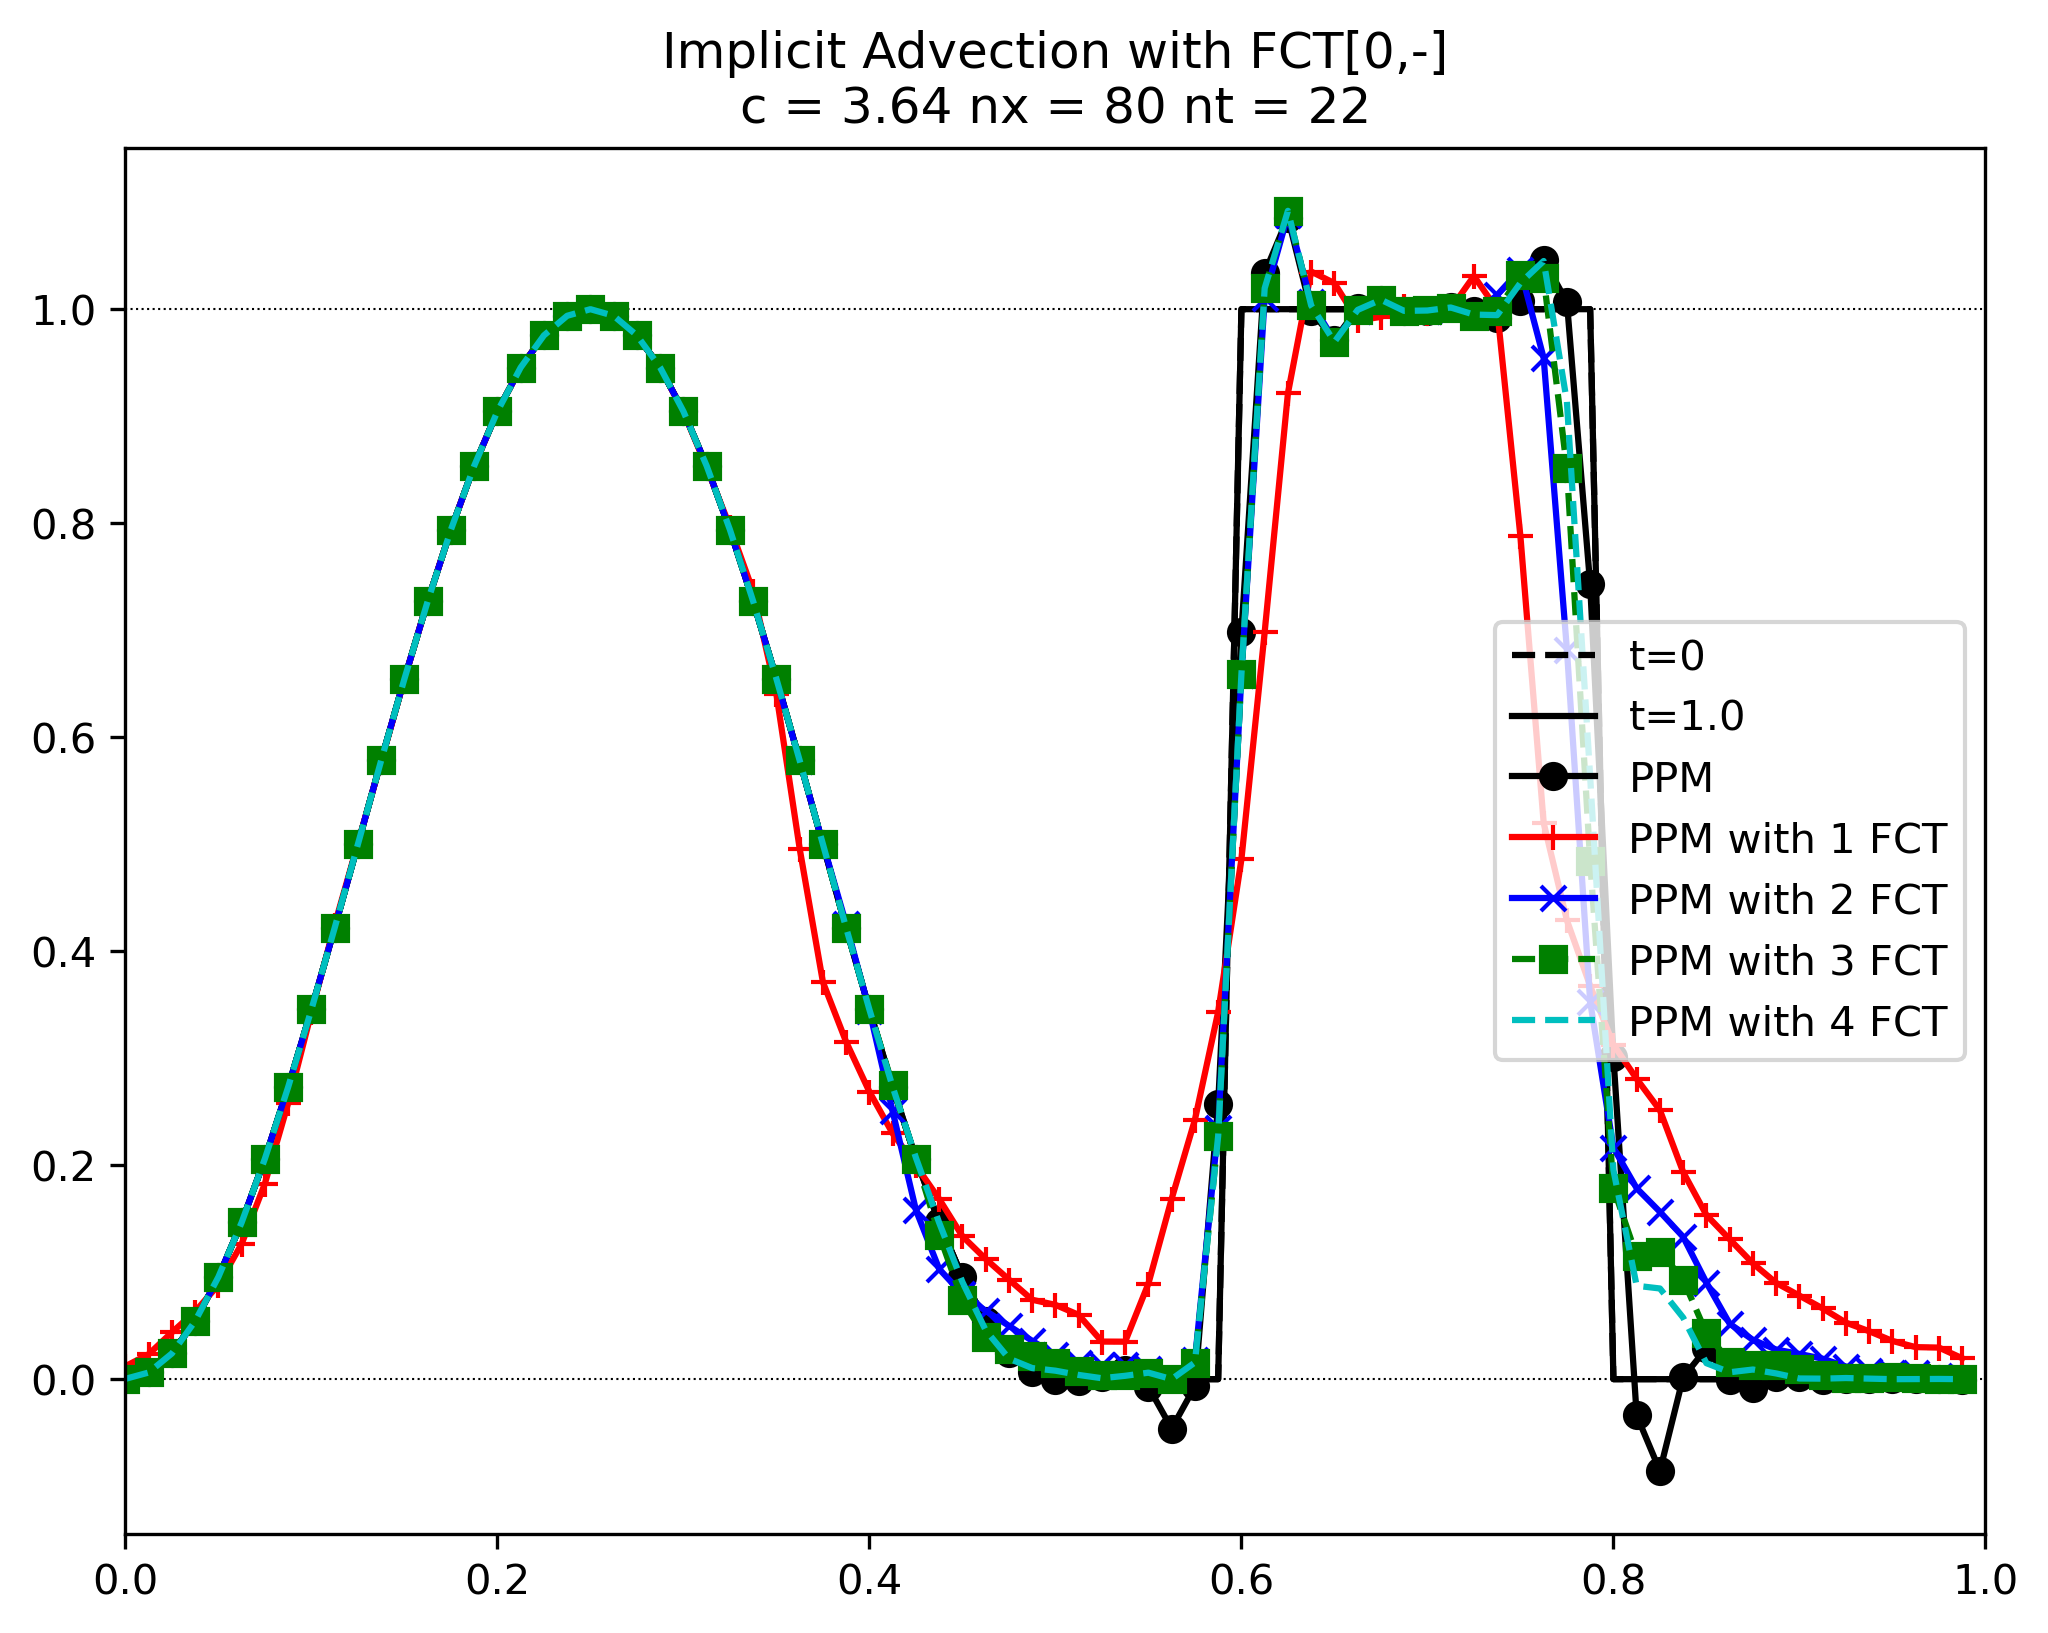

In [12]:
# PPM with iterations of Jacobi implicit, monotonic FCT[0,] with c = 3.6
compareSchemes(
    {"nt": 22, "nx":80, "c":80/22, "initialConditions":combi,
     "title": "Implicit Advection with FCT[0,-]",
     "fileName": "plots/PPM_c36_J_FCT0-.pdf"},
    [PPMflux, FCT, FCT, FCT, FCT],
    [{}, {"nCorr": 1, "minPhi":0, "maxPhi":1000, "Jacobi": True},
             {"nCorr": 2, "minPhi":0, "maxPhi":1000, "Jacobi": True},
             {"nCorr": 3, "minPhi":0, "maxPhi":1000, "Jacobi": True},
             {"nCorr": 4, "minPhi":0, "maxPhi":1000, "Jacobi": True}],
    ['PPM', 'PPM with 1 FCT', 'PPM with 2 FCT', 'PPM with 3 FCT',
     'PPM with 4 FCT'])

In [ ]:
# Comparison with Amber's results on doubleFCT.py
compareSchemes(
    {"nt" : int(100/6.25), "nx": 40, "c": 2.5, "initialConditions": combi,
     "title": "Quasi-cubic advection with Trapezoidal-implicit",
     "fileName": "plots/qC_c2p5_FCT.pdf"},
    [quasiCubicFlux, FCT, FCT, FCT, FCT, FCT, FCT],
    [{"explicit": False, "alpha": 0.5},
     {"nCorr": 1, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5},
     {"nCorr": 2, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5},
     {"nCorr": 3, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5},
     {"nCorr": 4, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5},
     {"nCorr": 5, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5},
     {"nCorr": 6, "HO": quasiCubicFlux, "explicit": False, "alpha": 0.5}],
    [r'cubic, $\alpha=0.5$', 'with 1 FCT', 'with 2 FCT', 'with 3 FCT', 
     'with 4 FCT', 'with 5 FCT', 'with 6 FCT'])